In [11]:
import numpy as np 
import pandas as pd 
df_sales = pd.read_csv('data/order.csv')
print('日期范围: %s ~ %s' % (df_sales['消费日期'].min(), df_sales['消费日期'].max())) #显示日期范围（格式转换前）
df_sales['消费日期'] = pd.to_datetime(df_sales['消费日期']) #转换日期格式
df_sales["总价"] = df_sales["单价"] * df_sales["数量"]
print('日期范围: %s ~ %s' % (df_sales['消费日期'].min(), df_sales['消费日期'].max()))#显示日期范围

日期范围: 1/1/2021 10:11 ~ 9/9/2020 9:20
日期范围: 2020-06-01 09:09:00 ~ 2021-06-09 12:31:00


In [12]:
df_sales = df_sales.loc[df_sales['消费日期'] < '2021-06-01'] #只保留整月数据
print('日期范围: %s ~ %s' % (df_sales['消费日期'].min(), df_sales['消费日期'].max())) #显示日期范围

日期范围: 2020-06-01 09:09:00 ~ 2021-05-31 17:39:00


In [13]:
df_sales_3m = df_sales[(df_sales.消费日期 > '2020-06-01') & (df_sales.消费日期 <= '2020-08-30')] #构建仅含头三个月数据的数据集
df_sales_3m.reset_index(drop=True) #重置索引

,订单号,产品码,消费日期,产品说明,数量,单价,用户码,城市,总价
0,536374,21258,2020-06-01 09:09:00,五彩玫瑰五支装,32,10.95,15100,北京,350.40
1,536376,22114,2020-06-01 09:32:00,茉莉花白色25枝,48,3.45,15291,上海,165.60
2,536376,21733,2020-06-01 09:32:00,教师节向日葵3枝尤加利5枝,64,2.55,15291,上海,163.20
3,536378,22386,2020-06-01 09:37:00,百合粉色10花苞,10,1.95,14688,北京,19.50
4,536378,85099C,2020-06-01 09:37:00,橙黄香槟色康乃馨,10,1.95,14688,北京,19.50
...,...,...,...,...,...,...,...,...,...
14837,545190,22937,2020-08-29 15:32:00,产品说明掩码,6,18.00,15656,苏州,108.00
14838,545190,22722,2020-08-29 15:32:00,产品说明掩码,4,39.50,15656,苏州,158.00
14839,545190,22457,2020-08-29 15:32:00,产品说明掩码,60,3.00,15656,苏州,180.00
14840,545190,22464,2020-08-29 15:32:00,产品说明掩码,12,25.00,15656,苏州,300.00


In [14]:
df_user_LTV = pd.DataFrame(df_sales['用户码'].unique()) #生成以用户码为主键的结构
df_user_LTV.columns = ['用户码'] #设定字段名
df_user_LTV.head() #显示头几行数据
df_R_value = df_sales_3m.groupby('用户码').消费日期.max().reset_index() #找到每个用户的最近消费日期，构建df_R_value对象
df_R_value.columns = ['用户码','最近购买日期'] #设定字段名
df_R_value['R值'] = (df_R_value['最近购买日期'].max() - df_R_value['最近购买日期']).dt.days #计算最新日期与上次消费日期的天数
df_user_LTV = pd.merge(df_user_LTV, df_R_value[['用户码','R值']], on='用户码') #把上次消费距最新日期的天数（R值）合并至df_user结构
df_F_value = df_sales_3m.groupby('用户码').消费日期.count().reset_index() #计算每个用户消费次数，构建df_F_value对象
df_F_value.columns = ['用户码','F值'] #设定字段名
df_user_LTV = pd.merge(df_user_LTV, df_F_value[['用户码','F值']], on='用户码') #把消费频率(F值)整合至df_user结构
df_M_value = df_sales_3m.groupby('用户码').总价.sum().reset_index() #计算每个用户三个月消费总额，构建df_M_value对象
df_M_value.columns = ['用户码','M值'] #设定字段名
df_user_LTV = pd.merge(df_user_LTV, df_M_value, on='用户码') #把消费总额整合至df_user结构
df_user_LTV #显示用户表结构

,用户码,R值,F值,M值
0,15100,45,6,635.10
1,15291,35,35,1329.95
2,14688,6,85,1472.28
3,15311,5,718,12730.01
4,15862,89,64,354.23
...,...,...,...,...
365,15951,1,22,375.17
366,14745,1,7,240.60
367,15724,0,5,103.65
368,15874,0,5,584.35


In [15]:
df_user_1y = df_sales.groupby('用户码')['总价'].sum().reset_index() #计算每个用户整年消费总额，构建df_user_1y对象
df_user_1y.columns = ['用户码','年度LTV'] #设定字段名
df_user_1y.head() #显示头几行数据
df_LTV = pd.merge(df_user_LTV, df_user_1y, on='用户码', how='left') #构建整体LTV训练数据集
df_LTV #显示df_LTV

,用户码,R值,F值,M值,年度LTV
0,15100,45,6,635.10,635.10
1,15291,35,35,1329.95,4596.51
2,14688,6,85,1472.28,4470.65
3,15311,5,718,12730.01,58352.77
4,15862,89,64,354.23,659.73
...,...,...,...,...,...
365,15951,1,22,375.17,375.17
366,14745,1,7,240.60,1167.16
367,15724,0,5,103.65,212.30
368,15874,0,5,584.35,4330.67


#### 特征集

In [16]:
X = df_LTV.drop(['用户码','年度LTV'],axis=1) #特征集
X.head() #显示特征集

,R值,F值,M值
0,45,6,635.10
1,35,35,1329.95
2,6,85,1472.28
3,5,718,12730.01
4,89,64,354.23


#### 标签集

In [17]:
y = df_LTV['年度LTV'] #标签集
y.head() #显示标签集

0      635.10
1     4596.51
2     4470.65
3    58352.77
4      659.73
Name: 年度LTV, dtype: float64

#### 拆分训练集、验证集和测试集

In [18]:
from sklearn.model_selection import train_test_split
# 先拆分训练集和其它集
X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.7,random_state = 36)
# 再把其它集拆分成验证集和测试集 
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5,random_state = 36)

#### 线性回归模型、决策树模型和随机森林模型

In [19]:
from sklearn.linear_model import LinearRegression #导入线性回归模型
from sklearn.tree import DecisionTreeRegressor #导入决策树回归模型
from sklearn.ensemble import RandomForestRegressor #导入随机森林回归模型
model_lr = LinearRegression() #创建线性回归模型
model_dtr = DecisionTreeRegressor() #创建决策树回归模型
model_rfr = RandomForestRegressor() #创建随机森林回归模型

#### 训练模型

In [20]:
model_lr.fit(X_train, y_train) #拟合线性回归模型
model_dtr.fit(X_train, y_train) #拟合决策树模型
model_rfr.fit(X_train, y_train) #拟合随机森林模型

RandomForestRegressor()

#### 评估模型

In [21]:
y_valid_preds_lr = model_lr.predict(X_valid) #用线性回归模型预测验证集
y_valid_preds_dtr = model_dtr.predict(X_valid) #用决策树模型预测验证集
y_valid_preds_rfr = model_rfr.predict(X_valid) #用随机森林模型预测验证集

In [22]:
X_valid.iloc[2] #随便选择一个数据

R值       1.00
F值     154.00
M值    1427.73
Name: 163, dtype: float64

In [23]:
print('真值:', y_valid.iloc[2])  #真值
print('线性回归预测值:', y_valid_preds_lr[2])  #线性回归模型预测值
print('决策树预测值:', y_valid_preds_dtr[2])  #决策树模型预测值
print('随机森林预测值:', y_valid_preds_rfr[2]) #随机森林模型预测值

真值: 4432.429999999991
线性回归预测值: 7474.418142488366
决策树预测值: 4074.57
随机森林预测值: 4086.1310000000026


#### 准确率

In [24]:
from sklearn.metrics import r2_score,   median_absolute_error #导入Sklearn评估模块
print('验证集上的R平方分数-线性回归: %0.4f' % r2_score(y_valid, model_lr.predict(X_valid)))
print('验证集上的R平方分数-决策树: %0.4f' % r2_score(y_valid, model_dtr.predict(X_valid)))
print('验证集上的R平方分数-随机森林: %0.4f' % r2_score(y_valid, model_rfr.predict(X_valid)))

验证集上的R平方分数-线性回归: 0.4410
验证集上的R平方分数-决策树: 0.2664
验证集上的R平方分数-随机森林: 0.4721


#### 随机森林验证测试值

Text(0.5, 1.0, '实际值 vs. 预测值')

/Users/01398068/.pyenv/versions/3.7.3/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 23454 (\N{CJK UNIFIED IDEOGRAPH-5B9E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/01398068/.pyenv/versions/3.7.3/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 38469 (\N{CJK UNIFIED IDEOGRAPH-9645}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/01398068/.pyenv/versions/3.7.3/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/01398068/.pyenv/versions/3.7.3/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/01398068/.pyenv/versions/3.7.3/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: Us

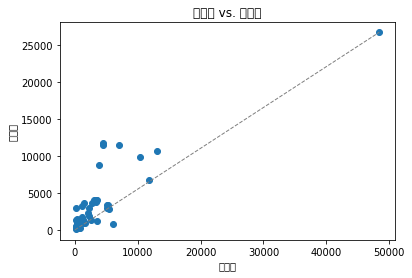

In [27]:
import matplotlib.pyplot as plt

y_test_preds = model_rfr.predict(X_test) #用模型预随机森林模型预测验证集
plt.scatter(y_test, y_test_preds) #预测值和实际值的散点图
plt.plot([0, max(y_test)], [0, max(y_test_preds)],   color='gray', lw=1, linestyle='--') #绘图
plt.xlabel('实际值') #X轴
plt.ylabel('预测值') #Y轴
plt.title('实际值 vs. 预测值') #标题